# For category

In [49]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# Category to Product mapping and weights
category_product_map = {
    "topup": ["ntc_topup", "ncell_topup", "smartcell_topup"],
    "bank_transaction": ["bank_withdrawal", "bank_deposit"],
    "bill_payment": ["electricity_bill", "water_bill", "internet_bill"],
    "entertainment": ["movie_ticket", "airline_ticket"],
    "loan": ["loan_repayment", "credit_card_payment"],
    "government": ["tax_payment", "govt_fee"],
    "insurance": ["insurance_payment"],
    "education": ["school_fee"],
    "shopping": ["online_shopping", "mobile_data_pack"]
}

category_weights = {
    "topup": 10,
    "bank_transaction": 6,
    "bill_payment": 8,
    "entertainment": 3,
    "loan": 5,
    "government": 3,
    "insurance": 4,
    "education": 5,
    "shopping": 7
}

# Festivals with format month-day and transaction multiplier
festivals = {
    "New Year Nepali": ("04-13", 3),
    "New Year English": ("01-01", 2.5),
    "Mother's Day": ("05-09", 1.5),
    "Buddha Jayanti": ("05-13", 1.8),
    "Teej": ("08-26", 2),
    "Indra Jatra": ("09-05", 1.5),
    "Dashain Day 1": ("10-05", 3),
    "Dashain Day 2": ("10-06", 3),
    "Dashain Day 3": ("10-07", 3),
    "Dashain Day 4": ("10-08", 3),
    "Dashain Day 5": ("10-09", 3),
    "Tihar Day 1": ("11-01", 3),
    "Tihar Day 2": ("11-02", 3),
    "Tihar Day 3": ("11-03", 3),
    "Tihar Day 4": ("11-04", 3),
    "Chhath": ("11-09", 2),
    "Christmas": ("12-25", 1.5),
    "Maghe Sankranti": ("01-14", 1.7),
    "Shivaratri": ("02-26", 2.5),
    "Holi": ("03-06", 2.8),
    "Valentine's Day": ("02-14", 2),
    "Rakhshya Bandhan": ("08-09", 1.5)
}

# Low activity events
low_activity_events = {
    "Earthquake": ["2023-06-15", "2023-06-16"],
    "Recession Alert": ["2024-02-10", "2024-02-11", "2024-02-12"]
}

# Date range
start_date = datetime(2022, 7, 1)
end_date = datetime(2025, 7, 1)
date_range = pd.date_range(start=start_date, end=end_date, freq="D")

# Helpers
def get_festival_info(date):
    month_day = date.strftime("%m-%d")
    for fest_name, (fest_day, multiplier) in festivals.items():
        if month_day == fest_day:
            return True, fest_name, multiplier
    return False, "", 1.0

def get_low_event_info(date):
    date_str = date.strftime("%Y-%m-%d")
    for event_name, dates in low_activity_events.items():
        if date_str in dates:
            return True, event_name, 0.3  # 70% drop in both amount and volume
    return False, "", 1.0

def get_trend_factors(date):
    days_passed = (date - start_date).days
    amount_trend = 0.02 * (days_passed / 365)
    volume_trend = 0.03 * (days_passed / 365)
    return amount_trend, volume_trend

# Data generation
data = []
for date in date_range:
    is_event, fest_name, fest_multiplier = get_festival_info(date)
    is_low, low_event_name, low_multiplier = get_low_event_info(date)
    is_holiday = is_event or date.weekday() == 6
    amount_trend, volume_trend = get_trend_factors(date)

    # Apply priority: low-activity overrides festival
    if is_low:
        event_name = low_event_name
        volume_multiplier = low_multiplier
        amount_multiplier = low_multiplier
    else:
        event_name = fest_name if is_event else ""
        volume_multiplier = fest_multiplier
        amount_multiplier = fest_multiplier

    base_txns = random.randint(50, 100)
    scaled_txns = int(base_txns * (1 + volume_trend) * volume_multiplier)

    for _ in range(scaled_txns):
        category = random.choices(list(category_product_map.keys()), weights=list(category_weights.values()))[0]
        product = random.choice(category_product_map[category])
        base_amount = random.randint(50, 5000)
        final_amount = base_amount * (1 + amount_trend) * random.uniform(1.0, amount_multiplier)

        data.append([
            date.strftime("%Y-%m-%d"),
            category,
            round(final_amount, 2),
        ])

# Final DataFrame
df = pd.DataFrame(data, columns=[
    "transaction_date", "category", "amount"
])
df.head(), len(df)


(  transaction_date      category  amount
 0       2022-07-01     education  4823.0
 1       2022-07-01         topup  1004.0
 2       2022-07-01     insurance   374.0
 3       2022-07-01  bill_payment  2057.0
 4       2022-07-01         topup   898.0,
 93013)

In [50]:
aggregated_df = df.groupby(['transaction_date', 'category']).agg(
    transaction_amount=('amount', 'sum'),
    transaction_count=('amount', 'count')
).reset_index()

In [51]:
unique_categories = aggregated_df['category'].unique()

for cat in unique_categories:
    rolling_mean_data = aggregated_df[aggregated_df['category'] == cat]['transaction_count'].rolling(window=7).mean()
    aggregated_df.loc[aggregated_df['category'] == cat, 'transaction_count'] = rolling_mean_data
    
    rolling_mean_data = aggregated_df[aggregated_df['category'] == cat]['transaction_amount'].rolling(window=7).mean()
    aggregated_df.loc[aggregated_df['category'] == cat, 'transaction_amount'] = rolling_mean_data

C:\Users\JARVIS\AppData\Local\Temp\ipykernel_13664\809536105.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[       nan        nan        nan ... 9.14285714 9.85714286 9.71428571]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  aggregated_df.loc[aggregated_df['category'] == cat, 'transaction_count'] = rolling_mean_data


In [52]:
aggregated_df['transaction_date'] = pd.to_datetime(aggregated_df['transaction_date']) 

In [53]:
aggregated_df.to_csv("category_prediction_data_v6.csv", index=False)

# For product

In [54]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# Category to Product mapping and weights
category_product_map = {
    "topup": ["ntc_topup", "ncell_topup", "smartcell_topup"],
    "bank_transaction": ["bank_withdrawal", "bank_deposit"],
    "bill_payment": ["electricity_bill", "water_bill", "internet_bill"],
    "entertainment": ["movie_ticket", "airline_ticket"],
    "loan": ["loan_repayment", "credit_card_payment"],
    "government": ["tax_payment", "govt_fee"],
    "insurance": ["insurance_payment"],
    "education": ["school_fee"],
    "shopping": ["online_shopping", "mobile_data_pack"]
}

category_weights = {
    "topup": 10,
    "bank_transaction": 6,
    "bill_payment": 8,
    "entertainment": 3,
    "loan": 5,
    "government": 3,
    "insurance": 4,
    "education": 5,
    "shopping": 7
}

# Festivals with format month-day and transaction multiplier
festivals = {
    "New Year Nepali": ("04-13", 3),
    "New Year English": ("01-01", 2.5),
    "Mother's Day": ("05-09", 1.5),
    "Buddha Jayanti": ("05-13", 1.8),
    "Teej": ("08-26", 2),
    "Indra Jatra": ("09-05", 1.5),
    "Dashain Day 1": ("10-05", 3),
    "Dashain Day 2": ("10-06", 3),
    "Dashain Day 3": ("10-07", 3),
    "Dashain Day 4": ("10-08", 3),
    "Dashain Day 5": ("10-09", 3),
    "Tihar Day 1": ("11-01", 3),
    "Tihar Day 2": ("11-02", 3),
    "Tihar Day 3": ("11-03", 3),
    "Tihar Day 4": ("11-04", 3),
    "Chhath": ("11-09", 2),
    "Christmas": ("12-25", 1.5),
    "Maghe Sankranti": ("01-14", 1.7),
    "Shivaratri": ("02-26", 2.5),
    "Holi": ("03-06", 2.8),
    "Valentine's Day": ("02-14", 2),
    "Rakhshya Bandhan": ("08-09", 1.5)
}

# Low activity events
low_activity_events = {
    "Earthquake": ["2023-06-15", "2023-06-16"],
    "Recession Alert": ["2024-02-10", "2024-02-11", "2024-02-12"]
}

# Date range
date_range = pd.date_range(start=start_date, end=end_date, freq="D")

# Helpers
def get_festival_info(date):
    month_day = date.strftime("%m-%d")
    for fest_name, (fest_day, multiplier) in festivals.items():
        if month_day == fest_day:
            return True, fest_name, multiplier
    return False, "", 1.0

def get_low_event_info(date):
    date_str = date.strftime("%Y-%m-%d")
    for event_name, dates in low_activity_events.items():
        if date_str in dates:
            return True, event_name, 0.3  # 70% drop in both amount and volume
    return False, "", 1.0

def get_trend_factors(date):
    days_passed = (date - start_date).days
    amount_trend = 0.02 * (days_passed / 365)
    volume_trend = 0.03 * (days_passed / 365)
    return amount_trend, volume_trend

# Data generation
data = []
for date in date_range:
    is_event, fest_name, fest_multiplier = get_festival_info(date)
    is_low, low_event_name, low_multiplier = get_low_event_info(date)
    is_holiday = is_event or date.weekday() == 6
    amount_trend, volume_trend = get_trend_factors(date)

    # Apply priority: low-activity overrides festival
    if is_low:
        event_name = low_event_name
        volume_multiplier = low_multiplier
        amount_multiplier = low_multiplier
    else:
        event_name = fest_name if is_event else ""
        volume_multiplier = fest_multiplier
        amount_multiplier = fest_multiplier

    base_txns = random.randint(50, 100)
    scaled_txns = int(base_txns * (1 + volume_trend) * volume_multiplier)

    for _ in range(scaled_txns):
        category = random.choices(list(category_product_map.keys()), weights=list(category_weights.values()))[0]
        product = random.choice(category_product_map[category])
        base_amount = random.randint(50, 5000)
        final_amount = base_amount * (1 + amount_trend) * random.uniform(1.0, amount_multiplier)

        data.append([
            date.strftime("%Y-%m-%d"),
            category,
            product,
            round(final_amount, 2),
        ])

# Final DataFrame
df = pd.DataFrame(data, columns=[
    "transaction_date", "category", 'product', "amount"
])
df.head(), len(df)


(  transaction_date   category          product  amount
 0       2022-07-01   shopping  online_shopping  2551.0
 1       2022-07-01      topup      ncell_topup  2105.0
 2       2022-07-01      topup        ntc_topup  1218.0
 3       2022-07-01      topup  smartcell_topup  3432.0
 4       2022-07-01  education       school_fee  2963.0,
 93458)

In [55]:
aggregated_df = df.groupby(['transaction_date', 'category', 'product']).agg(
    transaction_amount=('amount', 'sum'),
).reset_index()

In [56]:
aggregated_df['transaction_date'] = pd.to_datetime(aggregated_df['transaction_date']) 

In [57]:
unique_products = aggregated_df['product'].unique()

for prod in unique_products:
    rolling_mean_data = aggregated_df[(aggregated_df['product'] == prod)]['transaction_amount'].rolling(window=7).mean()
    aggregated_df.loc[aggregated_df['product'] == prod, 'transaction_amount'] = rolling_mean_data

In [58]:
aggregated_df.to_csv("product_prediction_data_v6.csv", index=False)

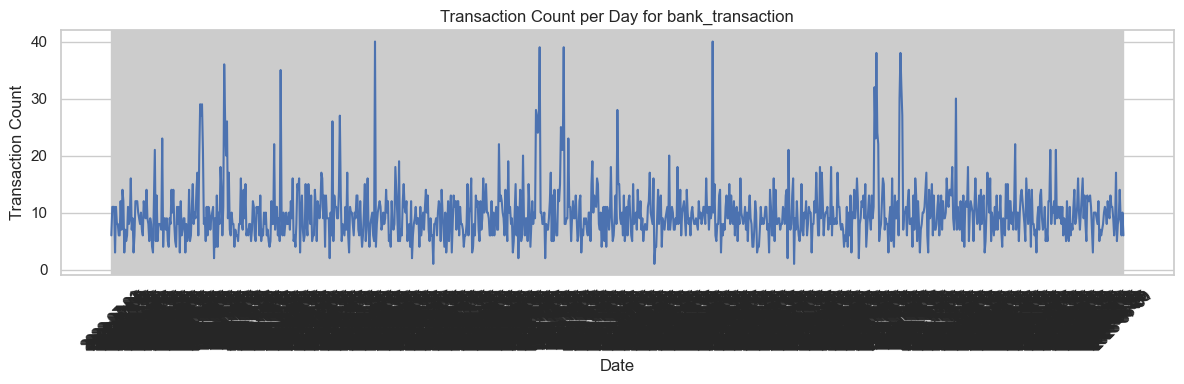

KeyboardInterrupt: 

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Parse date and sort

df["category"] = df["category"].astype(str)

# Group by transaction_date and category
grouped = df.groupby(["transaction_date", "category"]).agg(
    transaction_count=("amount", "count"),
    transaction_amount=("amount", "sum")
).reset_index()

# Unique categories
categories = grouped["category"].unique()

# Set style
sns.set(style="whitegrid")

# Plot for each category
for cat in categories:
    cat_data = grouped[grouped["category"] == cat]

    # Count Plot
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=cat_data, x="transaction_date", y="transaction_count")
    plt.title(f"Transaction Count per Day for {cat}")
    plt.xlabel("Date")
    plt.ylabel("Transaction Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Amount Plot
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=cat_data, x="transaction_date", y="transaction_amount")
    plt.title(f"Transaction Amount per Day for {cat}")
    plt.xlabel("Date")
    plt.ylabel("Transaction Amount (NPR)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
